### Data processing

# RAN WITH PYTHON 3.12

In [1]:
import torch

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
import pandas as pd
import os


if os.path.exists("big_merged_dataset.csv"):
    # Read the CSV file
    merged_df = pd.read_csv("big_merged_dataset.csv")
    headline_data = pd.read_csv('analyst_ratings_processed.csv' , quotechar='"', quoting=2, delimiter=",")
    print("CSV file exists. DataFrame loaded successfully.")
else:
    print("CSV file does not exist. Processing starts, this takes approximately 3 minutes")

    headline_data = pd.read_csv('analyst_ratings_processed.csv' , quotechar='"', quoting=2, delimiter=",")



    # Function to check if the value is a string
    def is_string(value):
        return isinstance(value, str)

    # Filter the DataFrame to keep only rows where the 'date' column is a string
    headline_data = headline_data[headline_data['date'].apply(is_string)]
    print(len(headline_data))



    headline_data["date"] = headline_data["date"].apply(lambda x: x.split(" ")[0])
    print("Date processing done.")



    # iterable list
    rows = list(headline_data.iterrows())
    print("Iterable list transformation done.")

    merged_df = pd.DataFrame(columns=["title","diff_bool","stock"])
    ticker = ""  # save the current stock ticker
    start_block_idx = 0     # save the current stock-block start index to subset dataframe

    # Iterate over the list with access to the next row
    for i in range(len(rows) - 1):
        current_index, current_row = rows[i]
        ticker = current_row["stock"]

        next_index, next_row = rows[i + 1]

        if next_row["stock"] != ticker:
            print("Processing stock: ", ticker, " | progress: " , (len(merged_df)/len(headline_data)))
            # create subset, merge, insert in plain
            temp_headline_dataset = headline_data.iloc[start_block_idx:current_index]
            
            try:
                raw_stock_data = pd.read_csv(f'stocks/{ticker}.csv') # read the current stock prices
            except:
                continue
            raw_stock_data = raw_stock_data.rename(columns={'Date': 'date'})

            # Calculate difference as boolean and numeric
            raw_stock_data["diff_num"] = raw_stock_data["Close"] - raw_stock_data["Open"]
            raw_stock_data["diff_bool"] = raw_stock_data["diff_num"].apply(lambda x: 1 if x > 0 else 0)

            # Make a small DF and join with headline data
            stock_data = raw_stock_data[["date","diff_bool"]]
            temp_merged_df = pd.merge(temp_headline_dataset, stock_data, on='date', how='inner')
            temp_merged_df = temp_merged_df[["title","diff_bool","stock"]]

            merged_df = pd.concat([merged_df, temp_merged_df], axis=0, ignore_index=True) #merging to the overall dataset

            # setting variables for further iteration of next stock-block
            start_block_idx = next_index
            ticker = next_row["stock"]

    #export the csv so that the computation does not always have to be made
    merged_df.to_csv("big_merged_dataset.csv",index=False)

df = merged_df
print("Length is: " , len(df), " rows")
print("The dataset holds ", round((len(df)/len(headline_data))*100,2) , "% of the overall rows.")
df.head()



CSV file exists. DataFrame loaded successfully.
Length is:  1272519  rows
The dataset holds  90.86 % of the overall rows.


,title,diff_bool,stock
0,Shares of several healthcare companies are tra...,0,A
1,Int'l. Air Transport Authority Chief Economist...,0,A
2,Wells Fargo Maintains Overweight on Agilent Te...,1,A
3,Shares of several technology companies are tra...,1,A
4,Shares of several healthcare companies are tra...,0,A


In [3]:
# for weak computation power, smaple n rows
df = df.sample(n=8000, random_state=1)
print(len(df))
df.head()

8000


,title,diff_bool,stock
103709,Avago Technologies Reports Q4 Adjusted EPS of ...,1,AVGO
392421,"UPDATE: Equity One Reports Q3 FFO $0.31, Recur...",0,EQY
1200797,"Stocks Which Set New 52-Week High Friday, Augu...",1,VSTM
404706,Citigroup Lists Key Asset Manager Winners,0,EV
369194,Mid-Morning Market Update: Markets Surge; Pric...,0,EDN


In [4]:
# remove stopwords an punktuation

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download the stopwords and punkt tokenizer from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean text by removing stopwords and punctuation
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if not word in stop_words]
    # Join the tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

# Apply the function to the DataFrame
df['title'] = df['title'].apply(clean_text)

# View the result
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,diff_bool,stock
103709,avago technologies reports adjusted eps,1,AVGO
392421,update equity one reports ffo recurring ffo vs...,0,EQY
1200797,stocks set new high friday august,1,VSTM
404706,citigroup lists key asset manager winners,0,EV
369194,market update markets surge pricesmart posts m...,0,EDN


In [5]:
# export as csv to be able to be fed into the tabular dataset
df.to_csv("train-processed.csv")

diff_bool
0    4062
1    3938
Name: count, dtype: int64


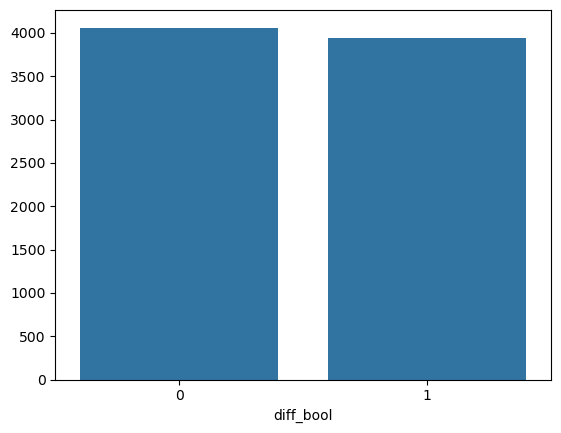

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dd = pd.Series(df["diff_bool"]).value_counts()
print(dd)
sns.barplot(x=dd.index,y=dd.values)
plt.show()

In [7]:
%pip install torchtext==0.6.0
%pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import spacy
import torch
from torchtext import data

# Define dataset

LABEL = data.LabelField(dtype=torch.long, batch_first=True, sequential=False)
TITLE = data.Field(tokenize="spacy", lower=True , tokenizer_language="en_core_web_sm")

fields = [("id",None), ("title", TITLE) , ("label", LABEL)]

stockDataset = data.TabularDataset(path="train-processed.csv",
                                   format="csv",
                                   fields=fields,
                                   skip_header=True)


(train,test,valid) = stockDataset.split(split_ratio=[0.8, 0.1, 0.1])


print( len(train), len(test) , len(valid) )
print( vars(train.examples[7])) # label = index????

6400 800 800
{'title': ['morgan', 'stanley', 'maintains', 'box', 'ships', 'overweight', 'lowers', 'pt'], 'label': '0'}


In [9]:
# Build vocabulary

vocab_size = 12321 # 10000
TITLE.build_vocab(train, max_size=vocab_size)
LABEL.build_vocab(train)

print("Length title vocabulary:", len(TITLE.vocab))
print("Most common words: ", TITLE.vocab.freqs.most_common(10))
# at this point no stopwords removal


Length title vocabulary: 8863
Most common words:  [('stocks', 749), ('vs', 707), ('eps', 622), ('est', 611), ('reports', 528), ('shares', 492), ('market', 398), ('update', 397), ('sales', 379), ('earnings', 371)]


In [10]:
# Define data iterator

device="cuda"

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(  (train, valid, test),
                                                                            batch_size = 32, 
                                                                            device=device,
                                                                            sort_key = lambda x: len(x.title),
                                                                            sort_within_batch = False   ) # Überlegen: sort_key weg


In [11]:
# Define Model

import torch.nn as nn
from torchtext.vocab import GloVe


# bidriectional, weird code is needed for bidirectional
# class ModelLSTM(nn.Module):
#     def __init__(self, vocab_size, hidden_size=100, embedding_dim=300, no_layers=1, dropout=0.25):
#         super(ModelLSTM, self).__init__()

#         # global_vectors = GloVe(name='6B', dim=embedding_dim)
#         # glove_weights = torch.load(f".vector_cache/glove.6B.{embedding_dim}d.txt.pt")
#         # self.embedding = nn.Embedding.from_pretrained(glove_weights[2])

#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.encoder = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=no_layers, dropout=dropout, bidirectional=True)
#         self.predictor = nn.Linear(hidden_size*2, 2)


#     def forward(self, seq):
#         embedded = self.embedding(seq)
#         output, (hidden, _) = self.encoder(embedded)
#         preds = self.predictor(hidden[-2:].transpose(0, 1).contiguous().view(-1, hidden.size(2)*2))
#         return preds

#non bidirectional LSTM
class ModelLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=100, embedding_dim=300, no_layers=1, dropout=0.25):
        super(ModelLSTM, self).__init__()

        # global_vectors = GloVe(name='6B', dim=embedding_dim)
        # glove_weights = torch.load(f".vector_cache/glove.6B.{embedding_dim}d.txt.pt")
        # self.embedding = nn.Embedding.from_pretrained(glove_weights[2])

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=no_layers, bidirectional=False) #dropout=dropout,
        self.drop = nn.Dropout(dropout)
        self.predictor = nn.Linear(hidden_size, 2)


    def forward(self, seq):
        embedded = self.embedding(seq)
        output, (hidden, _) = self.encoder(embedded)
        preds = self.drop(hidden[-1])
        preds = self.predictor(preds)
        return preds


# model GRU
# class ModelLSTM(nn.Module):
#     def __init__(self, vocab_size, hidden_size=100, embedding_dim=300, no_layers=1, dropout=0.25):
#         super(ModelLSTM, self).__init__()

#         # global_vectors = GloVe(name='6B', dim=embedding_dim)
#         # glove_weights = torch.load(f".vector_cache/glove.6B.{embedding_dim}d.txt.pt")
#         # self.embedding = nn.Embedding.from_pretrained(glove_weights[2])

#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.encoder = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=no_layers, bidirectional=False) #dropout=dropout,
#         self.drop = nn.Dropout(dropout)
#         self.predictor = nn.Linear(hidden_size, 2)


#     def forward(self, seq):
#         embedded = self.embedding(seq)
#         output, hidden = self.encoder(embedded)
#         preds = self.drop(hidden[-1])
#         preds = self.predictor(preds)
#         return preds

# Assuming you have defined vocab_size and device
hidden = 100 # 100
embed = 300  #300
number_layers = 1 #1
dropout_rate = 0.25

model = ModelLSTM(vocab_size, hidden, embed, number_layers,dropout_rate )
model.to(device)


ModelLSTM(
  (embedding): Embedding(12321, 300)
  (encoder): LSTM(300, 100)
  (drop): Dropout(p=0.25, inplace=False)
  (predictor): Linear(in_features=100, out_features=2, bias=True)
)

Epoch: 1, Training Loss: 0.44, Training Accuracy: 0.51, Validation Loss: 0.19, Validation Accuracy: 0.54
Epoch: 2, Training Loss: 0.44, Training Accuracy: 0.50, Validation Loss: 0.19, Validation Accuracy: 0.51
Epoch: 3, Training Loss: 0.44, Training Accuracy: 0.52, Validation Loss: 0.19, Validation Accuracy: 0.51
Epoch: 4, Training Loss: 0.43, Training Accuracy: 0.58, Validation Loss: 0.20, Validation Accuracy: 0.50
Epoch: 5, Training Loss: 0.40, Training Accuracy: 0.64, Validation Loss: 0.21, Validation Accuracy: 0.49
Epoch: 6, Training Loss: 0.33, Training Accuracy: 0.72, Validation Loss: 0.23, Validation Accuracy: 0.52
Epoch: 7, Training Loss: 0.26, Training Accuracy: 0.79, Validation Loss: 0.26, Validation Accuracy: 0.52
Epoch: 8, Training Loss: 0.20, Training Accuracy: 0.84, Validation Loss: 0.30, Validation Accuracy: 0.53
Epoch: 9, Training Loss: 0.17, Training Accuracy: 0.87, Validation Loss: 0.34, Validation Accuracy: 0.51
Epoch: 10, Training Loss: 0.14, Training Accuracy: 0.89

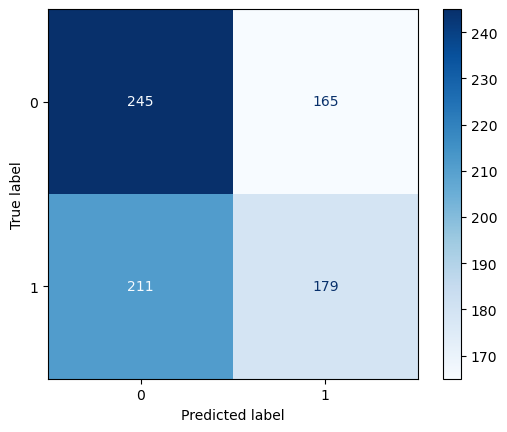

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



 # Lists to store training and validation losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


epochs=10
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay 
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(predict, labels):
    _, preds = torch.max(predict, 1)
    correct = torch.sum(preds == labels).item()
    return correct / len(labels)

def train(epochs, model, optimizer, criterion, train_iterator, valid_iterator):

    best_valid_loss = float('inf')
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        training_correct = 0
        valid_correct = 0

        model.train()
        for batch_idx, batch in enumerate(train_iterator):
            optimizer.zero_grad()
            predict = model(batch.title)
            loss = criterion(predict, batch.label)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * batch.title.size(0)
            training_correct += torch.sum(torch.argmax(predict, 1) == batch.label).item()

        training_loss /= len(train_iterator.dataset)
        training_accuracy = training_correct / len(train_iterator.dataset)

        model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_iterator):
                predict = model(batch.title)
                loss = criterion(predict, batch.label)
                valid_loss += loss.item() * batch.title.size(0)
                valid_correct += torch.sum(torch.argmax(predict, 1) == batch.label).item()

        valid_loss /= len(valid_iterator.dataset)
        valid_accuracy = valid_correct / len(valid_iterator.dataset)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_book_model.pt')  # Save best model

        print('Epoch: {}, Training Loss: {:.2f}, Training Accuracy: {:.2f}, '
              'Validation Loss: {:.2f}, Validation Accuracy: {:.2f}'
              .format(epoch, training_loss, training_accuracy, valid_loss, valid_accuracy))
        
        # Append losses and accuracies to lists
        train_losses.append(training_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(training_accuracy)
        valid_accuracies.append(valid_accuracy)

    # Create confusion matrix
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_iterator):
            predict = model(batch.title)
            preds = torch.argmax(predict, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.label.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

train(epochs, model, optimizer, criterion, train_iterator, valid_iterator)


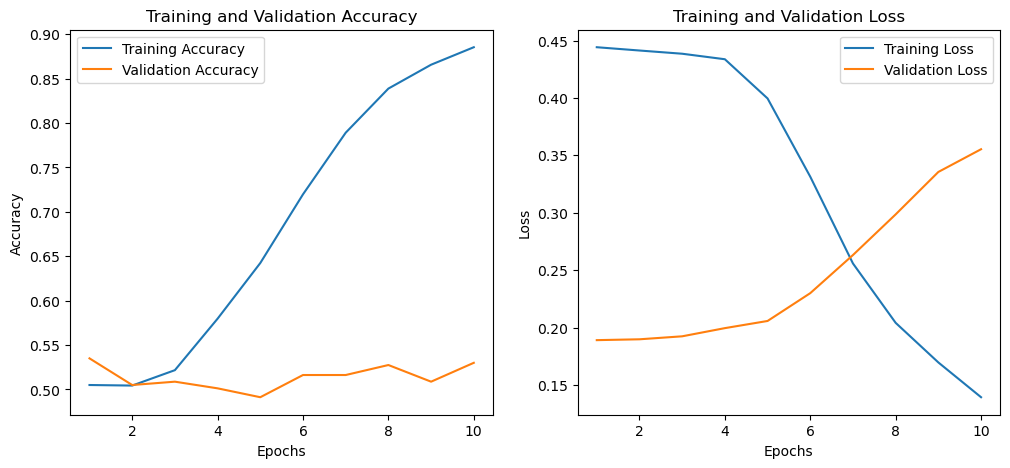

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Qualtiy Metrics

In [14]:
# with classification_report function

from sklearn.metrics import classification_report

def evaluate_model(model, data_iterator):
    model.eval()
    y_true = []
    y_pred = []

    for batch_idx, batch in enumerate(data_iterator):
        predictions = model(batch.title)
        _, predicted_labels = predictions.max(dim=1)
        y_true.extend(batch.label.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=["Stock Down", "Stock Up"])
    print(report)

# Call this method after training to evaluate on test/validation data
evaluate_model(model, test_iterator)
print("######")
evaluate_model(model, valid_iterator)




# calculate extra

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_iterator):
    model.eval()
    y_true = []
    y_pred = []

    for batch_idx, batch in enumerate(data_iterator):
        predictions = model(batch.title)
        _, predicted_labels = predictions.max(dim=1)
        y_true.extend(batch.label.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))

# Call this method after training to evaluate on test/validation data
print("---------------------------------------")
evaluate_model(model, test_iterator)
print("######")
evaluate_model(model, valid_iterator)



              precision    recall  f1-score   support

  Stock Down       0.58      0.57      0.58       449
    Stock Up       0.47      0.48      0.47       351

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800

######
              precision    recall  f1-score   support

  Stock Down       0.54      0.60      0.57       410
    Stock Up       0.52      0.46      0.49       390

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800

---------------------------------------
Accuracy: 0.5312
Precision: 0.5254
Recall: 0.5255
F1-score: 0.5254
######
Accuracy: 0.5300
Precision: 0.5288
Recall: 0.5283
F1-score: 0.5268


## hyperparamter tunign

In [15]:
break before hyperparametertuning

SyntaxError: invalid syntax (901614464.py, line 1)

In [ ]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def calculate_accuracy(predict, labels):
    _, preds = torch.max(predict, 1)
    correct = torch.sum(preds == labels).item()
    return correct / len(labels)

def train_and_evaluate(epochs, model, optimizer, criterion, train_iterator, valid_iterator):
    best_valid_loss = float('inf')
    best_valid_accuracy = 0.0
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        training_correct = 0
        valid_correct = 0

        model.train()
        for batch_idx, batch in enumerate(train_iterator):
            optimizer.zero_grad()
            predict = model(batch.title)
            loss = criterion(predict, batch.label)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * batch.title.size(0)
            training_correct += torch.sum(torch.argmax(predict, 1) == batch.label).item()

        training_loss /= len(train_iterator.dataset)
        training_accuracy = training_correct / len(train_iterator.dataset)

        model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_iterator):
                predict = model(batch.title)
                loss = criterion(predict, batch.label)
                valid_loss += loss.item() * batch.title.size(0)
                valid_correct += torch.sum(torch.argmax(predict, 1) == batch.label).item()

        valid_loss /= len(valid_iterator.dataset)
        valid_accuracy = valid_correct / len(valid_iterator.dataset)

        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            best_model_state = model.state_dict()

        #print(f'Epoch: {epoch}, Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f}, ' f'Validation Loss: {valid_loss:.2f}, Validation Accuracy: {valid_accuracy:.2f}')

    return best_valid_accuracy, best_model_state


device="cuda"

# Hyperparameters to tune
learning_rates = [0.00001, 0.001, 0.01]
weight_decay_list = [1e-5, 1e-3]

hidden_sizes = [50, 100, 150]
embedding_dims = [75, 125, 200]
number_layers=[2,5,10]
dropout_rates=[0.2, 0.5]

epochs_list = [5, 10]

# Placeholder for best model and its hyperparameters
best_hyperparams = None
best_accuracy = 0.0
best_model_state = None

total_combinations = len(learning_rates) * len(hidden_sizes) * len(embedding_dims) * len(epochs_list) * len(weight_decay_list) * len(number_layers) * len(dropout_rates)
completed_combinations = 0

# Iterate through all combinations of hyperparameters
for lr, hidden_size, embedding_dim, epochs, wd, no_layers, dropout in itertools.product(learning_rates, hidden_sizes, embedding_dims, epochs_list, weight_decay_list, number_layers, dropout_rates):
    # Initialize the model with the current set of hyperparameters
    model = ModelLSTM(vocab_size, hidden_size=hidden_size, embedding_dim=embedding_dim, no_layers=no_layers, dropout=dropout)  # Adjust model initialization as per your model definition
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    valid_accuracy, model_state = train_and_evaluate(epochs, model, optimizer, criterion, train_iterator, valid_iterator)

    completed_combinations += 1
    progress = (completed_combinations / total_combinations) * 100
    print(f'Progress: {progress:.2f}%')

    # Check if the current model is the best one
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_hyperparams = (lr, hidden_size, embedding_dim, epochs, wd, no_layers, dropout)
        best_model_state = model_state
        torch.save(best_model_state, 'best_book_model.pt')
        print(f'New best model found with accuracy: {best_accuracy:.2f}')
        print(f'Hyperparameters - Learning Rate: {lr}, Hidden Size: {hidden_size}, Embedding Dim: {embedding_dim}, Epochs: {epochs}, Weight Decay: {wd}, Number Layers: {no_layers}, Dropout_rate: {dropout}'), 

# Final best model details
print('Best Validation Accuracy:', best_accuracy)
print('Best Hyperparameters:', best_hyperparams)


Progress: 0.15%
New best model found with accuracy: 0.50
Hyperparameters - Learning Rate: 1e-05, Hidden Size: 50, Embedding Dim: 75, Epochs: 5, Weight Decay: 1e-05, Number Layers: 2, Dropout_rate: 0.2
Progress: 0.31%
Progress: 0.46%
New best model found with accuracy: 0.51
Hyperparameters - Learning Rate: 1e-05, Hidden Size: 50, Embedding Dim: 75, Epochs: 5, Weight Decay: 1e-05, Number Layers: 5, Dropout_rate: 0.2
Progress: 0.62%
Progress: 0.77%
Progress: 0.93%
Progress: 1.08%
New best model found with accuracy: 0.52
Hyperparameters - Learning Rate: 1e-05, Hidden Size: 50, Embedding Dim: 75, Epochs: 5, Weight Decay: 0.001, Number Layers: 2, Dropout_rate: 0.2
Progress: 1.23%
Progress: 1.39%
Progress: 1.54%
Progress: 1.70%
Progress: 1.85%
Progress: 2.01%
New best model found with accuracy: 0.52
Hyperparameters - Learning Rate: 1e-05, Hidden Size: 50, Embedding Dim: 75, Epochs: 10, Weight Decay: 1e-05, Number Layers: 2, Dropout_rate: 0.2
Progress: 2.16%
Progress: 2.31%
Progress: 2.47%
Pro

In [ ]:
# import itertools
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchtext import data



# # Hyperparameters to tune
# learning_rates = [0.00001, 0.001, 0.01]
# hidden_sizes = [50, 100, 150]
# embedding_dims = [200, 300, 400]
# epochs = [5, 10]
# weight_decay=[1e-5, 1e-3]

# # Initialize best validation loss to infinity
# best_valid_loss = float('inf')

# # Grid Search
# for lr, hidden_size, embedding_dim, num_epochs in itertools.product(learning_rates, hidden_sizes, embedding_dims, epochs):
    
#     # Initialize the model with current set of hyperparameters
#     model = ModelLSTM(vocab_size, hidden, embed, number_layers, dropout_rate)
#     model.to(device)
    
#     # Define optimizer and loss function
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()
    
#     # Training and validation loop
#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_iterator:
#             optimizer.zero_grad()
#             predictions = model(batch.title)
#             loss = criterion(predictions, batch.label)
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
        
#         # Validation
#         model.eval()
#         valid_loss = 0
#         with torch.no_grad():
#             for batch in valid_iterator:
#                 predictions = model(batch.title)
#                 loss = criterion(predictions, batch.label)
#                 valid_loss += loss.item()
                
#         # Average validation loss for this epoch
#         valid_loss /= len(valid_iterator)
        
#         # Print progress
#         print(f'Epoch: {epoch+1}, LR: {lr}, Hidden: {hidden_size}, Embed: {embedding_dim}, Valid Loss: {valid_loss}')
        
#         # Update best model if validation loss improves
#         if valid_loss < best_valid_loss:
#             best_valid_loss = valid_loss
#             torch.save(model.state_dict(), 'best_model.pt')
#             print(f"Best model saved with LR: {lr}, Hidden: {hidden_size}, Embed: {embedding_dim}, Valid Loss: {valid_loss}")

# # Load and use the best model
# # best_model = ModelLSTM(vocab_size, best_hidden_size, best_embedding_dim)
# # best_model.load_state_dict(torch.load('best_model.pt'))
# # best_model.to(device)

# # Further code for evaluation and usage of best_model
